In [1]:
!pip install https://github.com/pmosconi/scallop/raw/master/target/wheels/scallopy-0.2.5-cp311-cp311-manylinux_2_34_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 63.4 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import google.colab
import os
import random
import scallopy
from tqdm import tqdm

In [3]:
def set_seed(seed=42):
  np.random.seed(seed)
  torch.manual_seed(seed)
  random.seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

In [4]:
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
PROJECT_DIR = "/content/drive/MyDrive/Sudoku Project/"
dataset_path = "/content/drive/MyDrive/Sudoku Project/sudoku_grids_dataset"

20250322_115601_detection.jpg
(400, 400) uint8


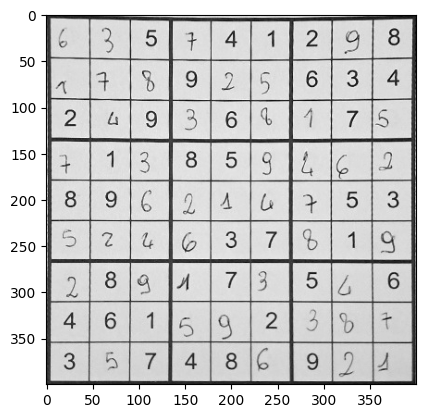

valid_grid_192_2025-04-28_21-09-17_detection.jpg
(400, 400) uint8


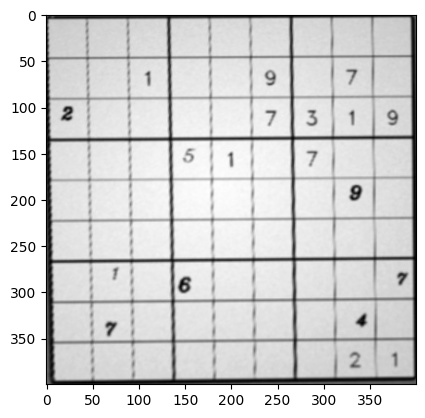

In [6]:
for folder in os.listdir(dataset_path):
  folder_list = [filename for filename in os.listdir(os.path.join(dataset_path, folder))]
  print(folder_list[0])
  image = plt.imread(os.path.join(dataset_path, f"{folder}/{folder_list[0]}"))
  plt.imshow(image, cmap="gray")
  print(image.shape, image.dtype)
  plt.show()

In [7]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)

In [8]:
print(f"Dataset size: {len(dataset)} images")
print(f"Class mapping: {dataset.class_to_idx}")

Dataset size: 780 images
Class mapping: {'invalid': 0, 'valid': 1}


In [9]:
sample_img, _ = dataset[0]
print(f"Sample image shape: {sample_img.shape}")

Sample image shape: torch.Size([1, 400, 400])


In [10]:
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

In [11]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size = 8,
                                           shuffle=True,
                                           num_workers=2
                                           )

test_loader = torch.utils.data.DataLoader(test_set,
                                           batch_size = 8,
                                           shuffle=False,
                                           num_workers=2
                                           )

(tensor([[[-0.0510, -0.0588, -0.0745,  ..., -0.3412, -0.3098, -0.2471],
         [-0.1686, -0.2078, -0.2471,  ..., -0.5608, -0.4824, -0.3882],
         [-0.3098, -0.3882, -0.4745,  ..., -0.6863, -0.6314, -0.5529],
         ...,
         [-0.6941, -0.7569, -0.8118,  ..., -0.8118, -0.7961, -0.7647],
         [-0.6078, -0.7020, -0.7569,  ..., -0.7255, -0.7020, -0.6706],
         [-0.5373, -0.6235, -0.6549,  ..., -0.6627, -0.6471, -0.6157]]]), 1)
torch.Size([1, 400, 400]) torch.float32
tensor([[[-0.0510, -0.0588, -0.0745,  ..., -0.3412, -0.3098, -0.2471],
         [-0.1686, -0.2078, -0.2471,  ..., -0.5608, -0.4824, -0.3882],
         [-0.3098, -0.3882, -0.4745,  ..., -0.6863, -0.6314, -0.5529],
         ...,
         [-0.6941, -0.7569, -0.8118,  ..., -0.8118, -0.7961, -0.7647],
         [-0.6078, -0.7020, -0.7569,  ..., -0.7255, -0.7020, -0.6706],
         [-0.5373, -0.6235, -0.6549,  ..., -0.6627, -0.6471, -0.6157]]])


torch.Size([8, 1, 400, 400]) torch.float32
torch.Size([8]) torch.int64


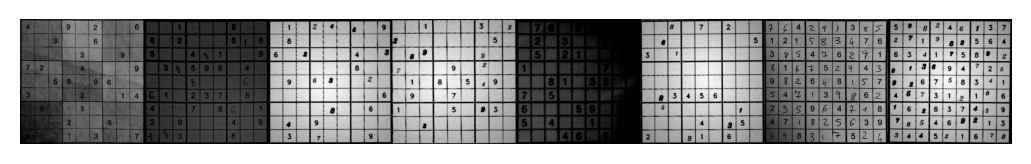

In [12]:
print(train_set[0])
print(train_set[0][0].shape, train_set[0][0].dtype)
print(train_set[0][0])

#function to visualize the images
def show_batch(images):
  g = torchvision.utils.make_grid(images, nrow=8)
  g = g.numpy().transpose((1, 2, 0))
  plt.figure(dpi=200)
  plt.imshow(g)
  plt.axis("off")
  plt.show()

images, labels = next(iter(train_loader))
print(images.shape, images.dtype)
print(labels.shape, labels.dtype)
show_batch(images)

In [13]:
def crop_cell_image_torch(image, grid_dim, cell_pixel_size, orig_cell_pos):
  cell_pos = (orig_cell_pos[1], orig_cell_pos[0])
  cell_w, cell_h = cell_pixel_size
  agent_offset_x, agent_offset_y = cell_pos[0]*cell_w, cell_pos[1]*cell_h
  agent_end_x, agent_end_y = agent_offset_x + cell_w, agent_offset_y + cell_h
  return image[:, agent_offset_y:agent_end_y, agent_offset_x:agent_end_x]

In [14]:
class CellClassifier(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.feature_extractor = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
        torch.nn.ReLU(),
        torch.nn.AvgPool2d(kernel_size=2, stride=2),
        torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
        torch.nn.ReLU(),
        torch.nn.AvgPool2d(kernel_size=2, stride=2),
        torch.nn.AdaptiveAvgPool2d((5, 5))
    )

    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(16 * 5 * 5, 120),
        torch.nn.ReLU(),
        torch.nn.Linear(120, 84),
        torch.nn.ReLU(),
        torch.nn.Linear(84, 10),
        torch.nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.feature_extractor(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

cellClassifier = CellClassifier()
x = torch.zeros(1, 1, 44, 44)
features = cellClassifier(x)
print(x.shape, "->", features.shape)
nparams = sum(p.numel() for p in cellClassifier.parameters())
print("Number of parameters:", nparams)

torch.Size([1, 1, 44, 44]) -> torch.Size([1, 10])
Number of parameters: 61706


In [15]:
class GridClassifier(torch.nn.Module):
  def __init__(self, grid_x, grid_y, image_dim, provenance, k):
    super(GridClassifier, self).__init__()
    self.grid_x = grid_x
    self.grid_y = grid_y
    self.image_dim = image_dim
    self.grid_dim = (self.grid_x, self.grid_y)
    self.cells = [(i, j) for i in range(self.grid_x) for j in range(self.grid_y)]
    self.cell_pixel_size = (self.image_dim // self.grid_x, self.image_dim // self.grid_y)
    self.provenance = provenance
    self.k = k

    self.cell_digit_net = CellClassifier()
    self.sudoku_rules = self.scallop_context(provenance, k)

  def scallop_context(self, provenance, k):
    scl_ctx = scallopy.ScallopContext(provenance=provenance, k=k)
    scl_ctx.add_relation("digit", (int, int, int)) #row, col, digit
    scl_ctx.add_relation("block", (int, int, int, int)) #row, col, block_row, block_col

    blocks = []
    for r in range(self.grid_x):
      for c in range(self.grid_y):
        br = r // 3
        bc = c // 3
        blocks.append((None, (r, c, br, bc)))
    scl_ctx.add_facts("block", blocks)

    scl_ctx.add_rule("row_conflict(r,d) :- digit(r, c1, d), digit(r, c2, d), c1 != c2")
    scl_ctx.add_rule("col_conflict(c,d) :- digit(r1, c, d), digit(r2, c, d), r1 != r2")
    scl_ctx.add_rule("block_conflict(br, bc, d) :- digit(r1, c1, d), digit(r2, c2, d), block(r1, c1, br, bc), block(r2, c2, br, bc), (r1 != r2 \/ c1 != c2)")

    scl_ctx.add_rule("conflict() :- (row_conflict(_,_) \/ col_conflict(_,_) \/ block_conflict(_,_,_))")
    scl_ctx.add_rule("classification() :- not conflict()")

    return scl_ctx

  def forward(self, x):
    batch_size, _, _, _ = x.shape
    num_cells = len(self.cells)
    cells = torch.stack([torch.stack([crop_cell_image_torch(x[i], self.grid_dim, self.cell_pixel_size, c) for c in self.cells]) for i in range(batch_size)])
    cells = cells.reshape(batch_size * num_cells, 1, self.cell_pixel_size[0], self.cell_pixel_size[1])
    digits = self.cell_digit_net(cells)
    batched_digits = digits.reshape(batch_size, num_cells, 10)

    batch_results = []

    for grid in range(batch_size):
      scl_ctx = self.scallop_context(self.provenance, self.k)
      digits = []

      for i, (row, col) in enumerate(self.cells):
        digit_probs = batched_digits[grid, i]
        pred_digit = torch.argmax(digit_probs).item()

        if pred_digit in range(1,10):
          prob = digit_probs[pred_digit]
          digits.append((prob, (row, col, pred_digit)))

      scl_ctx.add_facts("digit", digits)
      scl_ctx.run()

      result_proofs = list(scl_ctx.relation("classification"))
      result = result_proofs[0][0]
      batch_results.append(result)

    return torch.stack(batch_results).unsqueeze(1).to(x.device)

grid_size = 9
image_dim = 400

classifier = GridClassifier(grid_x = grid_size,
                            grid_y = grid_size,
                            image_dim = image_dim,
                            provenance = "difftopkproofs",
                            k=3)

x = torch.zeros(32, 1, 400, 400)
features = classifier(x)
print(x.shape, "->", features.shape)
nparams = sum(p.numel() for p in classifier.parameters())
print("Number of parameters:", nparams)

torch.Size([32, 1, 400, 400]) -> torch.Size([32, 1])
Number of parameters: 61706


In [16]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
classifier.to(DEVICE)

cuda


GridClassifier(
  (cell_digit_net): CellClassifier(
    (feature_extractor): Sequential(
      (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (4): ReLU()
      (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (6): AdaptiveAvgPool2d(output_size=(5, 5))
    )
    (classifier): Sequential(
      (0): Linear(in_features=400, out_features=120, bias=True)
      (1): ReLU()
      (2): Linear(in_features=120, out_features=84, bias=True)
      (3): ReLU()
      (4): Linear(in_features=84, out_features=10, bias=True)
      (5): Softmax(dim=1)
    )
  )
)

In [17]:
loss_fun = torch.nn.BCELoss()
loss_fun.to(DEVICE)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

In [19]:
EPOCHS = 200
step = 0

for epoch in tqdm(range(EPOCHS)):
  for images, labels in train_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    optimizer.zero_grad()
    probs = classifier(images)
    loss = loss_fun(probs, labels.float().unsqueeze(1))
    loss.backward()
    optimizer.step()
    step += 1
    if step % 50 == 0:
      acc = ((probs > 0.5).long() == labels.unsqueeze(1)).float().mean()
      print(f"{step}[{epoch}]: loss {loss.item():.4f}  acc: {100 * acc:.1f}")
  torch.save(classifier.state_dict(), PROJECT_DIR + "scallop_classifier.pt")

  0%|          | 0/200 [00:00<?, ?it/s]

50[0]: loss 0.6329  acc: 50.0


  0%|          | 1/200 [00:42<2:21:56, 42.80s/it]

100[1]: loss 0.9082  acc: 25.0
150[1]: loss 0.5136  acc: 75.0


  1%|          | 2/200 [01:26<2:23:52, 43.60s/it]

200[2]: loss 0.7573  acc: 50.0


  2%|▏         | 3/200 [02:11<2:23:55, 43.84s/it]

250[3]: loss 0.4568  acc: 87.5
300[3]: loss 0.5118  acc: 87.5


  2%|▏         | 4/200 [02:54<2:22:50, 43.73s/it]

350[4]: loss 0.6486  acc: 62.5


  2%|▎         | 5/200 [03:37<2:21:18, 43.48s/it]

400[5]: loss 0.6066  acc: 50.0
450[5]: loss 0.5335  acc: 50.0


  3%|▎         | 6/200 [04:20<2:19:35, 43.18s/it]

500[6]: loss 0.5905  acc: 50.0


  4%|▎         | 7/200 [05:01<2:17:09, 42.64s/it]

550[7]: loss 0.4707  acc: 75.0
600[7]: loss 0.2614  acc: 100.0


  4%|▍         | 8/200 [05:42<2:14:14, 41.95s/it]

650[8]: loss 0.7113  acc: 62.5
700[8]: loss 0.5674  acc: 75.0


  4%|▍         | 9/200 [06:23<2:12:21, 41.58s/it]

750[9]: loss 0.4439  acc: 75.0


  5%|▌         | 10/200 [07:03<2:10:35, 41.24s/it]

800[10]: loss 0.3903  acc: 62.5
850[10]: loss 0.5292  acc: 87.5


  6%|▌         | 11/200 [07:44<2:09:34, 41.14s/it]

900[11]: loss 0.5743  acc: 37.5


  6%|▌         | 12/200 [08:25<2:08:28, 41.01s/it]

950[12]: loss 0.4231  acc: 75.0
1000[12]: loss 0.4753  acc: 87.5


  6%|▋         | 13/200 [09:05<2:07:09, 40.80s/it]

1050[13]: loss 0.3347  acc: 87.5


  7%|▋         | 14/200 [09:46<2:06:37, 40.85s/it]

1100[14]: loss 0.4170  acc: 50.0
1150[14]: loss 0.5683  acc: 62.5


  8%|▊         | 15/200 [10:26<2:05:32, 40.72s/it]

1200[15]: loss 0.4754  acc: 75.0


  8%|▊         | 16/200 [11:07<2:04:32, 40.61s/it]

1250[16]: loss 0.5682  acc: 50.0
1300[16]: loss 0.2747  acc: 87.5


  8%|▊         | 17/200 [11:46<2:02:57, 40.32s/it]

1350[17]: loss 0.5138  acc: 62.5
1400[17]: loss 0.1969  acc: 87.5


  9%|▉         | 18/200 [12:26<2:02:05, 40.25s/it]

1450[18]: loss 0.7094  acc: 50.0


 10%|▉         | 19/200 [13:06<2:01:01, 40.12s/it]

1500[19]: loss 0.5198  acc: 62.5
1550[19]: loss 1.0646  acc: 50.0


 10%|█         | 20/200 [13:46<2:00:26, 40.15s/it]

1600[20]: loss 0.5051  acc: 75.0


 10%|█         | 21/200 [14:26<1:59:39, 40.11s/it]

1650[21]: loss 0.4879  acc: 75.0
1700[21]: loss 0.4982  acc: 75.0


 11%|█         | 22/200 [15:06<1:58:28, 39.94s/it]

1750[22]: loss 0.4434  acc: 100.0


 12%|█▏        | 23/200 [15:45<1:57:10, 39.72s/it]

1800[23]: loss 0.8276  acc: 62.5
1850[23]: loss 0.2374  acc: 87.5


 12%|█▏        | 24/200 [16:24<1:55:53, 39.51s/it]

1900[24]: loss 0.5126  acc: 75.0


 12%|█▎        | 25/200 [17:03<1:54:25, 39.23s/it]

1950[24]: loss 0.6049  acc: 50.0
2000[25]: loss 0.3224  acc: 87.5


 13%|█▎        | 26/200 [17:42<1:53:38, 39.19s/it]

2050[26]: loss 0.6983  acc: 37.5
2100[26]: loss 0.4149  acc: 50.0


 14%|█▎        | 27/200 [18:21<1:52:51, 39.14s/it]

2150[27]: loss 0.6060  acc: 37.5


 14%|█▍        | 28/200 [19:00<1:52:03, 39.09s/it]

2200[28]: loss 0.5630  acc: 62.5
2250[28]: loss 0.2106  acc: 75.0


 14%|█▍        | 29/200 [19:39<1:51:05, 38.98s/it]

2300[29]: loss 0.1797  acc: 100.0


 15%|█▌        | 30/200 [20:17<1:49:57, 38.81s/it]

2350[30]: loss 0.4080  acc: 75.0
2400[30]: loss 0.5260  acc: 50.0


 16%|█▌        | 31/200 [20:56<1:49:15, 38.79s/it]

2450[31]: loss 0.1920  acc: 87.5


 16%|█▌        | 32/200 [21:34<1:48:17, 38.68s/it]

2500[32]: loss 0.4724  acc: 62.5
2550[32]: loss 0.4631  acc: 62.5


 16%|█▋        | 33/200 [22:12<1:46:52, 38.40s/it]

2600[33]: loss 0.5001  acc: 62.5
2650[33]: loss 0.3554  acc: 75.0


 17%|█▋        | 34/200 [22:50<1:46:13, 38.40s/it]

2700[34]: loss 0.5285  acc: 62.5


 18%|█▊        | 35/200 [23:29<1:45:51, 38.49s/it]

2750[35]: loss 0.3109  acc: 62.5
2800[35]: loss 0.6122  acc: 50.0


 18%|█▊        | 36/200 [24:08<1:45:19, 38.53s/it]

2850[36]: loss 0.4711  acc: 50.0


 18%|█▊        | 37/200 [24:45<1:43:52, 38.24s/it]

2900[37]: loss 0.5261  acc: 62.5
2950[37]: loss 0.4468  acc: 75.0


 19%|█▉        | 38/200 [25:24<1:43:49, 38.45s/it]

3000[38]: loss 0.3608  acc: 75.0


 20%|█▉        | 39/200 [26:03<1:43:33, 38.60s/it]

3050[39]: loss 0.3720  acc: 75.0
3100[39]: loss 12.8487  acc: 62.5


 20%|██        | 40/200 [26:41<1:42:32, 38.45s/it]

3150[40]: loss 0.3359  acc: 87.5


 20%|██        | 41/200 [27:19<1:41:30, 38.30s/it]

3200[41]: loss 0.4485  acc: 75.0
3250[41]: loss 0.4385  acc: 87.5


 21%|██        | 42/200 [27:57<1:40:53, 38.31s/it]

3300[42]: loss 0.3459  acc: 87.5
3350[42]: loss 0.3973  acc: 50.0


 22%|██▏       | 43/200 [28:35<1:39:59, 38.21s/it]

3400[43]: loss 0.3236  acc: 75.0


 22%|██▏       | 44/200 [29:13<1:39:05, 38.11s/it]

3450[44]: loss 0.2994  acc: 75.0
3500[44]: loss 0.3180  acc: 100.0


 22%|██▎       | 45/200 [29:51<1:38:02, 37.95s/it]

3550[45]: loss 0.3987  acc: 87.5


 23%|██▎       | 46/200 [30:29<1:37:46, 38.10s/it]

3600[46]: loss 0.4203  acc: 87.5
3650[46]: loss 0.3793  acc: 87.5


 24%|██▎       | 47/200 [31:07<1:37:10, 38.11s/it]

3700[47]: loss 0.2234  acc: 87.5


 24%|██▍       | 48/200 [31:45<1:36:06, 37.94s/it]

3750[48]: loss 0.4516  acc: 62.5
3800[48]: loss 12.7345  acc: 75.0


 24%|██▍       | 49/200 [32:23<1:35:49, 38.08s/it]

3850[49]: loss 0.4018  acc: 75.0


 25%|██▌       | 50/200 [33:01<1:34:49, 37.93s/it]

3900[49]: loss 0.4321  acc: 50.0
3950[50]: loss 0.6334  acc: 50.0


 26%|██▌       | 51/200 [33:38<1:33:36, 37.69s/it]

4000[51]: loss 0.3905  acc: 75.0
4050[51]: loss 12.6937  acc: 75.0


 26%|██▌       | 52/200 [34:15<1:32:24, 37.46s/it]

4100[52]: loss 0.6242  acc: 62.5


 26%|██▋       | 53/200 [34:53<1:31:50, 37.49s/it]

4150[53]: loss 0.2111  acc: 100.0
4200[53]: loss 0.3772  acc: 87.5


 27%|██▋       | 54/200 [35:30<1:31:17, 37.52s/it]

4250[54]: loss 0.2715  acc: 75.0


 28%|██▊       | 55/200 [36:08<1:30:47, 37.57s/it]

4300[55]: loss 0.5399  acc: 62.5
4350[55]: loss 0.3490  acc: 100.0


 28%|██▊       | 56/200 [36:46<1:30:18, 37.63s/it]

4400[56]: loss 0.3884  acc: 75.0


 28%|██▊       | 57/200 [37:23<1:29:41, 37.64s/it]

4450[57]: loss 0.4610  acc: 50.0
4500[57]: loss 0.4468  acc: 75.0


 29%|██▉       | 58/200 [38:01<1:29:08, 37.66s/it]

4550[58]: loss 0.2595  acc: 87.5
4600[58]: loss 0.3415  acc: 75.0


 30%|██▉       | 59/200 [38:39<1:28:23, 37.62s/it]

4650[59]: loss 0.3731  acc: 62.5


 30%|███       | 60/200 [39:17<1:28:09, 37.78s/it]

4700[60]: loss 0.0272  acc: 100.0
4750[60]: loss 0.4666  acc: 75.0


 30%|███       | 61/200 [39:54<1:27:26, 37.74s/it]

4800[61]: loss 0.4518  acc: 62.5


 31%|███       | 62/200 [40:31<1:25:46, 37.29s/it]

4850[62]: loss 0.5804  acc: 50.0
4900[62]: loss 0.6898  acc: 37.5


 32%|███▏      | 63/200 [41:08<1:25:01, 37.24s/it]

4950[63]: loss 0.7092  acc: 50.0


 32%|███▏      | 64/200 [41:45<1:24:26, 37.25s/it]

5000[64]: loss 0.1011  acc: 87.5
5050[64]: loss 0.3793  acc: 75.0


 32%|███▎      | 65/200 [42:23<1:24:04, 37.37s/it]

5100[65]: loss 0.4026  acc: 62.5


 33%|███▎      | 66/200 [43:00<1:23:25, 37.35s/it]

5150[66]: loss 0.4401  acc: 87.5
5200[66]: loss 0.4714  acc: 75.0


 34%|███▎      | 67/200 [43:37<1:22:24, 37.17s/it]

5250[67]: loss 0.2550  acc: 87.5
5300[67]: loss 0.3257  acc: 87.5


 34%|███▍      | 68/200 [44:14<1:21:59, 37.27s/it]

5350[68]: loss 0.7356  acc: 50.0


 34%|███▍      | 69/200 [44:51<1:21:16, 37.22s/it]

5400[69]: loss 0.6249  acc: 50.0
5450[69]: loss 0.3502  acc: 75.0


 35%|███▌      | 70/200 [45:29<1:21:04, 37.42s/it]

5500[70]: loss 0.5538  acc: 50.0


 36%|███▌      | 71/200 [46:07<1:20:56, 37.65s/it]

5550[71]: loss 0.4437  acc: 75.0
5600[71]: loss 0.5923  acc: 50.0


 36%|███▌      | 72/200 [46:46<1:20:51, 37.90s/it]

5650[72]: loss 0.3132  acc: 75.0


 36%|███▋      | 73/200 [47:24<1:20:05, 37.84s/it]

5700[73]: loss 0.3859  acc: 87.5
5750[73]: loss 0.3840  acc: 100.0


 37%|███▋      | 74/200 [48:02<1:19:32, 37.88s/it]

5800[74]: loss 0.3407  acc: 75.0


 38%|███▊      | 75/200 [48:39<1:18:33, 37.71s/it]

5850[74]: loss 0.3306  acc: 87.5
5900[75]: loss 0.4279  acc: 87.5


 38%|███▊      | 76/200 [49:16<1:17:37, 37.56s/it]

5950[76]: loss 0.5979  acc: 50.0
6000[76]: loss 0.2621  acc: 100.0


 38%|███▊      | 77/200 [49:52<1:16:05, 37.12s/it]

6050[77]: loss 0.7479  acc: 37.5


 39%|███▉      | 78/200 [50:29<1:15:33, 37.16s/it]

6100[78]: loss 0.4512  acc: 87.5
6150[78]: loss 0.4028  acc: 62.5


 40%|███▉      | 79/200 [51:07<1:14:54, 37.15s/it]

6200[79]: loss 0.3654  acc: 87.5


 40%|████      | 80/200 [51:43<1:14:10, 37.09s/it]

6250[80]: loss 0.1850  acc: 75.0
6300[80]: loss 0.3822  acc: 87.5


 40%|████      | 81/200 [52:19<1:12:54, 36.76s/it]

6350[81]: loss 0.3954  acc: 87.5


 41%|████      | 82/200 [52:57<1:12:32, 36.88s/it]

6400[82]: loss 0.3586  acc: 75.0
6450[82]: loss 0.5555  acc: 62.5


 42%|████▏     | 83/200 [53:34<1:12:03, 36.96s/it]

6500[83]: loss 0.3950  acc: 87.5
6550[83]: loss 0.4098  acc: 87.5


 42%|████▏     | 84/200 [54:11<1:11:37, 37.05s/it]

6600[84]: loss 0.2852  acc: 75.0


 42%|████▎     | 85/200 [54:47<1:10:27, 36.76s/it]

6650[85]: loss 0.2315  acc: 87.5
6700[85]: loss 0.4340  acc: 62.5


 43%|████▎     | 86/200 [55:25<1:10:14, 36.97s/it]

6750[86]: loss 0.4528  acc: 87.5


 44%|████▎     | 87/200 [56:02<1:09:49, 37.07s/it]

6800[87]: loss 0.6015  acc: 37.5
6850[87]: loss 0.6829  acc: 62.5


 44%|████▍     | 88/200 [56:39<1:09:07, 37.03s/it]

6900[88]: loss 0.4013  acc: 87.5


 44%|████▍     | 89/200 [57:15<1:08:03, 36.79s/it]

6950[89]: loss 0.3992  acc: 75.0
7000[89]: loss 0.6503  acc: 50.0


 45%|████▌     | 90/200 [57:52<1:07:26, 36.79s/it]

7050[90]: loss 0.5718  acc: 50.0


 46%|████▌     | 91/200 [58:29<1:07:08, 36.96s/it]

7100[91]: loss 0.1824  acc: 87.5
7150[91]: loss 0.3549  acc: 87.5


 46%|████▌     | 92/200 [59:07<1:06:57, 37.20s/it]

7200[92]: loss 0.3526  acc: 62.5
7250[92]: loss 0.3954  acc: 75.0


 46%|████▋     | 93/200 [59:43<1:05:41, 36.84s/it]

7300[93]: loss 0.3759  acc: 87.5


 47%|████▋     | 94/200 [1:00:20<1:04:56, 36.76s/it]

7350[94]: loss 0.2685  acc: 87.5
7400[94]: loss 0.4275  acc: 62.5


 48%|████▊     | 95/200 [1:00:57<1:04:36, 36.92s/it]

7450[95]: loss 0.7857  acc: 25.0


 48%|████▊     | 96/200 [1:01:34<1:03:57, 36.90s/it]

7500[96]: loss 0.5103  acc: 87.5
7550[96]: loss 0.2554  acc: 87.5


 48%|████▊     | 97/200 [1:02:10<1:02:49, 36.59s/it]

7600[97]: loss 0.2766  acc: 87.5


 49%|████▉     | 98/200 [1:02:46<1:02:10, 36.57s/it]

7650[98]: loss 0.3563  acc: 87.5
7700[98]: loss 0.9667  acc: 50.0


 50%|████▉     | 99/200 [1:03:23<1:01:35, 36.59s/it]

7750[99]: loss 0.3060  acc: 75.0


 50%|█████     | 100/200 [1:03:59<1:00:48, 36.49s/it]

7800[99]: loss 0.1982  acc: 87.5
7850[100]: loss 0.1341  acc: 100.0


 50%|█████     | 101/200 [1:04:35<59:51, 36.28s/it]  

7900[101]: loss 0.2821  acc: 100.0
7950[101]: loss 0.3760  acc: 75.0


 51%|█████     | 102/200 [1:05:11<59:25, 36.38s/it]

8000[102]: loss 0.3600  acc: 75.0


 52%|█████▏    | 103/200 [1:05:48<59:02, 36.52s/it]

8050[103]: loss 0.1964  acc: 87.5
8100[103]: loss 0.4195  acc: 75.0


 52%|█████▏    | 104/200 [1:06:24<58:08, 36.33s/it]

8150[104]: loss 0.5556  acc: 50.0


 52%|█████▎    | 105/200 [1:07:01<57:36, 36.38s/it]

8200[105]: loss 0.4793  acc: 75.0
8250[105]: loss 0.3484  acc: 62.5


 53%|█████▎    | 106/200 [1:07:38<57:18, 36.58s/it]

8300[106]: loss 0.3660  acc: 75.0


 54%|█████▎    | 107/200 [1:08:14<56:48, 36.65s/it]

8350[107]: loss 0.3140  acc: 100.0
8400[107]: loss 0.4168  acc: 62.5


 54%|█████▍    | 108/200 [1:08:50<55:52, 36.44s/it]

8450[108]: loss 0.2514  acc: 87.5
8500[108]: loss 0.4612  acc: 75.0


 55%|█████▍    | 109/200 [1:09:27<55:14, 36.42s/it]

8550[109]: loss 0.1458  acc: 100.0


 55%|█████▌    | 110/200 [1:10:03<54:38, 36.43s/it]

8600[110]: loss 0.3932  acc: 62.5
8650[110]: loss 0.4774  acc: 87.5


 56%|█████▌    | 111/200 [1:10:39<53:40, 36.19s/it]

8700[111]: loss 0.2631  acc: 87.5


 56%|█████▌    | 112/200 [1:11:16<53:16, 36.33s/it]

8750[112]: loss 0.3534  acc: 75.0
8800[112]: loss 0.6646  acc: 62.5


 56%|█████▋    | 113/200 [1:11:53<53:00, 36.56s/it]

8850[113]: loss 0.3220  acc: 75.0


 57%|█████▋    | 114/200 [1:12:29<52:13, 36.43s/it]

8900[114]: loss 0.4282  acc: 75.0
8950[114]: loss 0.2111  acc: 87.5


 57%|█████▊    | 115/200 [1:13:04<51:12, 36.14s/it]

9000[115]: loss 0.3897  acc: 75.0


 58%|█████▊    | 116/200 [1:13:41<50:42, 36.22s/it]

9050[116]: loss 0.3653  acc: 87.5
9100[116]: loss 0.3568  acc: 75.0


 58%|█████▊    | 117/200 [1:14:17<50:09, 36.26s/it]

9150[117]: loss 0.1047  acc: 87.5
9200[117]: loss 0.2350  acc: 75.0


 59%|█████▉    | 118/200 [1:14:52<49:10, 35.98s/it]

9250[118]: loss 12.6341  acc: 87.5


 60%|█████▉    | 119/200 [1:15:28<48:23, 35.85s/it]

9300[119]: loss 0.1952  acc: 87.5
9350[119]: loss 0.4676  acc: 75.0


 60%|██████    | 120/200 [1:16:05<48:12, 36.15s/it]

9400[120]: loss 0.3902  acc: 75.0


 60%|██████    | 121/200 [1:16:41<47:28, 36.05s/it]

9450[121]: loss 0.2122  acc: 87.5
9500[121]: loss 0.4964  acc: 75.0


 61%|██████    | 122/200 [1:17:17<47:01, 36.18s/it]

9550[122]: loss 0.3580  acc: 87.5


 62%|██████▏   | 123/200 [1:17:54<46:33, 36.28s/it]

9600[123]: loss 0.3087  acc: 75.0
9650[123]: loss 0.3298  acc: 75.0


 62%|██████▏   | 124/200 [1:18:30<45:54, 36.25s/it]

9700[124]: loss 0.2582  acc: 87.5


 62%|██████▎   | 125/200 [1:19:06<45:09, 36.13s/it]

9750[124]: loss 0.3058  acc: 87.5
9800[125]: loss 0.2513  acc: 87.5


 63%|██████▎   | 126/200 [1:19:42<44:38, 36.20s/it]

9850[126]: loss 0.2678  acc: 87.5
9900[126]: loss 0.1667  acc: 100.0


 64%|██████▎   | 127/200 [1:20:18<44:09, 36.29s/it]

9950[127]: loss 0.2487  acc: 100.0


 64%|██████▍   | 128/200 [1:20:53<43:06, 35.92s/it]

10000[128]: loss 0.4345  acc: 62.5
10050[128]: loss 0.2752  acc: 75.0


 64%|██████▍   | 129/200 [1:21:30<42:37, 36.03s/it]

10100[129]: loss 0.3529  acc: 87.5


 65%|██████▌   | 130/200 [1:22:06<42:03, 36.05s/it]

10150[130]: loss 0.2722  acc: 75.0
10200[130]: loss 0.4834  acc: 75.0


 66%|██████▌   | 131/200 [1:22:41<41:10, 35.80s/it]

10250[131]: loss 0.2546  acc: 100.0


 66%|██████▌   | 132/200 [1:23:17<40:36, 35.83s/it]

10300[132]: loss 0.2054  acc: 100.0
10350[132]: loss 0.3292  acc: 87.5


 66%|██████▋   | 133/200 [1:23:53<40:09, 35.96s/it]

10400[133]: loss 0.0971  acc: 100.0
10450[133]: loss 0.2520  acc: 100.0


 67%|██████▋   | 134/200 [1:24:28<39:08, 35.58s/it]

10500[134]: loss 0.4621  acc: 50.0


 68%|██████▊   | 135/200 [1:25:04<38:46, 35.79s/it]

10550[135]: loss 0.1980  acc: 87.5
10600[135]: loss 0.2506  acc: 87.5


 68%|██████▊   | 136/200 [1:25:40<38:19, 35.93s/it]

10650[136]: loss 0.2356  acc: 87.5


 68%|██████▊   | 137/200 [1:26:16<37:28, 35.70s/it]

10700[137]: loss 0.1813  acc: 87.5
10750[137]: loss 0.1689  acc: 87.5


 69%|██████▉   | 138/200 [1:26:51<36:55, 35.73s/it]

10800[138]: loss 0.8887  acc: 50.0


 70%|██████▉   | 139/200 [1:27:27<36:21, 35.76s/it]

10850[139]: loss 0.1548  acc: 87.5
10900[139]: loss 0.3828  acc: 75.0


 70%|███████   | 140/200 [1:28:02<35:32, 35.54s/it]

10950[140]: loss 0.0529  acc: 100.0


 70%|███████   | 141/200 [1:28:38<35:01, 35.61s/it]

11000[141]: loss 0.2600  acc: 87.5
11050[141]: loss 0.3111  acc: 87.5


 71%|███████   | 142/200 [1:29:14<34:28, 35.67s/it]

11100[142]: loss 0.3128  acc: 75.0
11150[142]: loss 0.3600  acc: 75.0


 72%|███████▏  | 143/200 [1:29:49<33:40, 35.45s/it]

11200[143]: loss 0.2720  acc: 87.5


 72%|███████▏  | 144/200 [1:30:25<33:16, 35.66s/it]

11250[144]: loss 0.4096  acc: 75.0
11300[144]: loss 0.3604  acc: 75.0


 72%|███████▎  | 145/200 [1:31:01<32:43, 35.70s/it]

11350[145]: loss 0.1490  acc: 87.5


 73%|███████▎  | 146/200 [1:31:36<32:00, 35.57s/it]

11400[146]: loss 0.2397  acc: 87.5
11450[146]: loss 0.2827  acc: 75.0


 74%|███████▎  | 147/200 [1:32:12<31:29, 35.65s/it]

11500[147]: loss 0.0061  acc: 100.0


 74%|███████▍  | 148/200 [1:32:47<30:48, 35.54s/it]

11550[148]: loss 0.2755  acc: 75.0
11600[148]: loss 0.3668  acc: 87.5


 74%|███████▍  | 149/200 [1:33:23<30:14, 35.58s/it]

11650[149]: loss 0.2518  acc: 75.0


 75%|███████▌  | 150/200 [1:33:59<29:41, 35.63s/it]

11700[149]: loss 0.2873  acc: 75.0
11750[150]: loss 0.4343  acc: 75.0


 76%|███████▌  | 151/200 [1:34:33<28:53, 35.38s/it]

11800[151]: loss 0.2063  acc: 87.5
11850[151]: loss 0.5019  acc: 62.5


 76%|███████▌  | 152/200 [1:35:09<28:18, 35.38s/it]

11900[152]: loss 0.1705  acc: 87.5


 76%|███████▋  | 153/200 [1:35:44<27:47, 35.48s/it]

11950[153]: loss 0.0818  acc: 100.0
12000[153]: loss 0.3429  acc: 75.0


 77%|███████▋  | 154/200 [1:36:19<26:59, 35.21s/it]

12050[154]: loss 0.3226  acc: 75.0


 78%|███████▊  | 155/200 [1:36:54<26:27, 35.27s/it]

12100[155]: loss 0.0975  acc: 100.0
12150[155]: loss 0.3082  acc: 87.5


 78%|███████▊  | 156/200 [1:37:30<25:53, 35.31s/it]

12200[156]: loss 0.1823  acc: 87.5


 78%|███████▊  | 157/200 [1:38:04<25:09, 35.11s/it]

12250[157]: loss 0.2514  acc: 87.5
12300[157]: loss 0.2088  acc: 87.5


 79%|███████▉  | 158/200 [1:38:40<24:39, 35.22s/it]

12350[158]: loss 0.3183  acc: 75.0
12400[158]: loss 0.1395  acc: 87.5


 80%|███████▉  | 159/200 [1:39:14<23:49, 34.87s/it]

12450[159]: loss 0.1714  acc: 87.5


 80%|████████  | 160/200 [1:39:49<23:20, 35.01s/it]

12500[160]: loss 0.0290  acc: 100.0
12550[160]: loss 0.1417  acc: 87.5


 80%|████████  | 161/200 [1:40:24<22:46, 35.03s/it]

12600[161]: loss 0.0561  acc: 100.0


 81%|████████  | 162/200 [1:40:59<22:05, 34.87s/it]

12650[162]: loss 0.1123  acc: 100.0
12700[162]: loss 0.3954  acc: 75.0


 82%|████████▏ | 163/200 [1:41:34<21:36, 35.03s/it]

12750[163]: loss 0.1434  acc: 87.5


 82%|████████▏ | 164/200 [1:42:09<20:56, 34.89s/it]

12800[164]: loss 0.4003  acc: 87.5
12850[164]: loss 0.1774  acc: 87.5


 82%|████████▎ | 165/200 [1:42:44<20:25, 35.01s/it]

12900[165]: loss 0.1880  acc: 87.5


 83%|████████▎ | 166/200 [1:43:19<19:50, 35.02s/it]

12950[166]: loss 0.1442  acc: 87.5
13000[166]: loss 0.1481  acc: 87.5


 84%|████████▎ | 167/200 [1:43:54<19:08, 34.80s/it]

13050[167]: loss 0.2015  acc: 100.0
13100[167]: loss 0.2985  acc: 87.5


 84%|████████▍ | 168/200 [1:44:28<18:34, 34.82s/it]

13150[168]: loss 0.3423  acc: 62.5


 84%|████████▍ | 169/200 [1:45:02<17:51, 34.55s/it]

13200[169]: loss 0.5415  acc: 75.0
13250[169]: loss 0.2589  acc: 100.0


 85%|████████▌ | 170/200 [1:45:37<17:19, 34.66s/it]

13300[170]: loss 0.1997  acc: 87.5


 86%|████████▌ | 171/200 [1:46:12<16:44, 34.63s/it]

13350[171]: loss 0.2469  acc: 75.0
13400[171]: loss 0.0241  acc: 100.0


 86%|████████▌ | 172/200 [1:46:46<16:06, 34.51s/it]

13450[172]: loss 0.0007  acc: 100.0


 86%|████████▋ | 173/200 [1:47:21<15:39, 34.79s/it]

13500[173]: loss 0.0405  acc: 100.0
13550[173]: loss 0.7008  acc: 50.0


 87%|████████▋ | 174/200 [1:47:55<14:57, 34.53s/it]

13600[174]: loss 0.5690  acc: 87.5


 88%|████████▊ | 175/200 [1:48:30<14:24, 34.58s/it]

13650[174]: loss 0.1294  acc: 100.0
13700[175]: loss 0.2863  acc: 87.5


 88%|████████▊ | 176/200 [1:49:04<13:46, 34.43s/it]

13750[176]: loss 0.3249  acc: 75.0
13800[176]: loss 0.0901  acc: 100.0


 88%|████████▊ | 177/200 [1:49:39<13:14, 34.54s/it]

13850[177]: loss 0.1999  acc: 87.5


 89%|████████▉ | 178/200 [1:50:13<12:36, 34.38s/it]

13900[178]: loss 0.1030  acc: 100.0
13950[178]: loss 0.1401  acc: 87.5


 90%|████████▉ | 179/200 [1:50:47<12:01, 34.35s/it]

14000[179]: loss 0.1679  acc: 100.0


 90%|█████████ | 180/200 [1:51:22<11:28, 34.42s/it]

14050[180]: loss 0.0318  acc: 100.0
14100[180]: loss 0.0345  acc: 100.0


 90%|█████████ | 181/200 [1:51:56<10:50, 34.23s/it]

14150[181]: loss 12.5650  acc: 87.5


 91%|█████████ | 182/200 [1:52:30<10:17, 34.29s/it]

14200[182]: loss 0.3171  acc: 75.0
14250[182]: loss 0.1450  acc: 100.0


 92%|█████████▏| 183/200 [1:53:03<09:38, 34.00s/it]

14300[183]: loss 0.0674  acc: 100.0
14350[183]: loss 0.0146  acc: 100.0


 92%|█████████▏| 184/200 [1:53:38<09:06, 34.14s/it]

14400[184]: loss 0.0726  acc: 100.0


 92%|█████████▎| 185/200 [1:54:11<08:28, 33.88s/it]

14450[185]: loss 12.6578  acc: 75.0
14500[185]: loss 0.3777  acc: 87.5


 93%|█████████▎| 186/200 [1:54:45<07:54, 33.86s/it]

14550[186]: loss 0.0726  acc: 100.0


 94%|█████████▎| 187/200 [1:55:18<07:16, 33.61s/it]

14600[187]: loss 0.3619  acc: 62.5
14650[187]: loss 0.3080  acc: 75.0


 94%|█████████▍| 188/200 [1:55:52<06:44, 33.74s/it]

14700[188]: loss 25.2010  acc: 62.5


 94%|█████████▍| 189/200 [1:56:25<06:08, 33.54s/it]

14750[189]: loss 0.3421  acc: 75.0
14800[189]: loss 0.0878  acc: 100.0


 95%|█████████▌| 190/200 [1:56:59<05:37, 33.74s/it]

14850[190]: loss 0.3007  acc: 87.5


 96%|█████████▌| 191/200 [1:57:32<05:02, 33.56s/it]

14900[191]: loss 0.1287  acc: 87.5
14950[191]: loss 0.1150  acc: 100.0


 96%|█████████▌| 192/200 [1:58:07<04:30, 33.81s/it]

15000[192]: loss 0.2241  acc: 87.5
15050[192]: loss 0.0738  acc: 100.0


 96%|█████████▋| 193/200 [1:58:40<03:55, 33.66s/it]

15100[193]: loss 0.0003  acc: 100.0


 97%|█████████▋| 194/200 [1:59:15<03:23, 33.91s/it]

15150[194]: loss 0.1540  acc: 100.0
15200[194]: loss 0.2437  acc: 87.5


 98%|█████████▊| 195/200 [1:59:48<02:48, 33.78s/it]

15250[195]: loss 0.0873  acc: 100.0


 98%|█████████▊| 196/200 [2:00:22<02:15, 33.83s/it]

15300[196]: loss 0.0260  acc: 100.0
15350[196]: loss 0.1027  acc: 100.0


 98%|█████████▊| 197/200 [2:00:55<01:41, 33.69s/it]

15400[197]: loss 0.0311  acc: 100.0


 99%|█████████▉| 198/200 [2:01:30<01:07, 34.00s/it]

15450[198]: loss 0.0156  acc: 100.0
15500[198]: loss 0.2886  acc: 75.0


100%|█████████▉| 199/200 [2:02:03<00:33, 33.76s/it]

15550[199]: loss 0.2073  acc: 87.5


100%|██████████| 200/200 [2:02:38<00:00, 36.79s/it]

15600[199]: loss 0.0263  acc: 100.0


In [20]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import math

correct = 0
total = 0
all_labels = []
all_preds = []
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

classifier.eval()
with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    probs = classifier(images)
    preds = (probs > 0.5).long().squeeze(1)

    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

    # Identify misclassified samples in the current batch
    misclassified_mask = (preds != labels)
    misclassified_images.extend(images[misclassified_mask].cpu())
    misclassified_labels.extend(labels[misclassified_mask].cpu())
    misclassified_preds.extend(preds[misclassified_mask].cpu())


classifier.train()

acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {100 * acc:.1f}%")

f1 = f1_score(all_labels, all_preds)
print(f"F1 Score: {100 * f1:.1f}%")

Accuracy: 69.2%
F1 Score: 72.7%


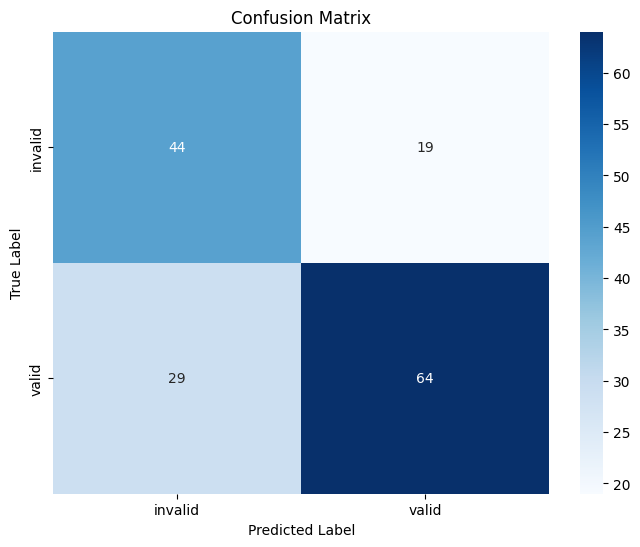

In [21]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Found 48 misclassified samples.
19 samples where invalid was classified as valid:


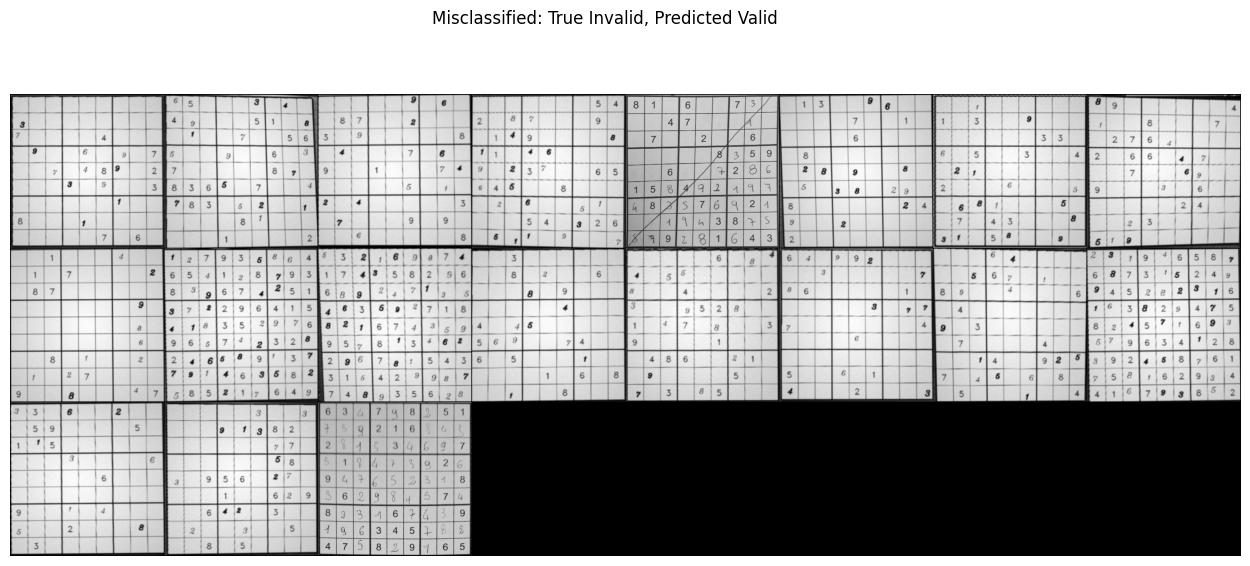

29 samples where valid was classified as invalid:


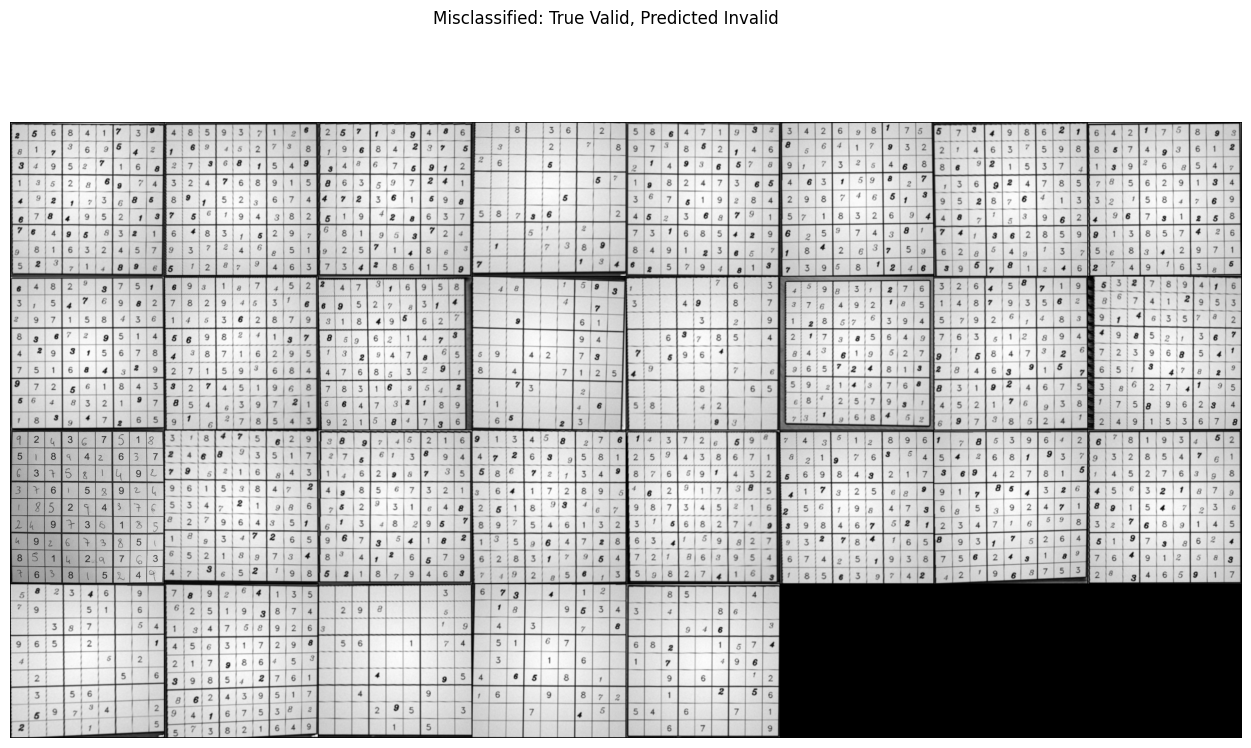

In [22]:
print(f"Found {len(misclassified_images)} misclassified samples.")

invalid_as_valid_images = []
invalid_as_valid_labels = []
invalid_as_valid_preds = []

valid_as_invalid_images = []
valid_as_invalid_labels = []
valid_as_invalid_preds = []

for i in range(len(misclassified_images)):
    true_label = misclassified_labels[i].item()
    pred_label = misclassified_preds[i].item()

    # Case 1: True label is invalid (0) but predicted as valid (1)
    if true_label == dataset.class_to_idx['invalid'] and pred_label == dataset.class_to_idx['valid']:
        invalid_as_valid_images.append(misclassified_images[i])
        invalid_as_valid_labels.append(misclassified_labels[i])
        invalid_as_valid_preds.append(misclassified_preds[i])
    # Case 2: True label is valid (1) but predicted as invalid (0)
    elif true_label == dataset.class_to_idx['valid'] and pred_label == dataset.class_to_idx['invalid']:
        valid_as_invalid_images.append(misclassified_images[i])
        valid_as_invalid_labels.append(misclassified_labels[i])
        valid_as_invalid_preds.append(misclassified_preds[i])

## Plotting Invalid Classified as Valid
print(f"{len(invalid_as_valid_images)} samples where invalid was classified as valid:")
if len(invalid_as_valid_images) > 0:
    n_cols = min(len(invalid_as_valid_images), 8)
    n_rows = math.ceil(len(invalid_as_valid_images) / n_cols)

    grid = torchvision.utils.make_grid(torch.stack(invalid_as_valid_images), nrow=n_cols, padding=2, normalize=True)
    grid = grid.numpy().transpose((1, 2, 0))

    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    plt.imshow(grid)
    plt.axis('off')
    plt.suptitle("Misclassified: True Invalid, Predicted Valid", y=1.02)
    plt.show()
else:
    print("No samples where invalid was classified as valid.")

## Plotting Valid Classified as Invalid
print(f"{len(valid_as_invalid_images)} samples where valid was classified as invalid:")
if len(valid_as_invalid_images) > 0:
    n_cols = min(len(valid_as_invalid_images), 8)
    n_rows = math.ceil(len(valid_as_invalid_images) / n_cols)

    grid = torchvision.utils.make_grid(torch.stack(valid_as_invalid_images), nrow=n_cols, padding=2, normalize=True)
    grid = grid.numpy().transpose((1, 2, 0))

    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    plt.imshow(grid)
    plt.axis('off')
    plt.suptitle("Misclassified: True Valid, Predicted Invalid", y=1.02)
    plt.show()
else:
    print("No samples where Valid was Classified as Invalid.")